This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [11]:
!pip install wget
!pip install unzip

  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1321 sha256=93cb03d9f276b04f9043baa9dc419c5a74d84e77f2a6428ff23338e14d7e7bd2
  Stored in directory: c:\users\max20\appdata\local\pip\cache\wheels\88\2c\2b\d12ab5bb9f34eba42f98231b969311f33d7dc1a2f484b902d1
Successfully built unzip


In [12]:
!python -m wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip


Saved under jena_climate_2009_2016.csv (1).zip


In [15]:
!python -m unzip jena_climate_2009_2016.csv.zip

**Inspecting the data of the Jena weather dataset**

In [17]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [18]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

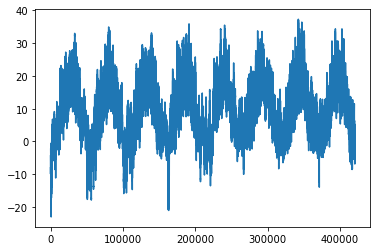

In [19]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

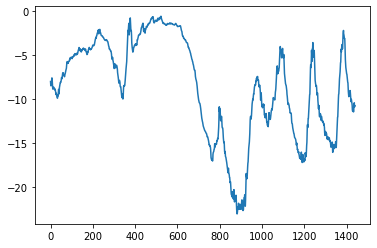

In [20]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [21]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [22]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [23]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [24]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [25]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [26]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 5s 6ms/step - loss: 14.0808 - mae: 2.8953 - val_loss: 11.2471 - val_mae: 2.6413
Epoch 2/10
819/819 [==============================] - 5s 6ms/step - loss: 9.3561 - mae: 2.4118 - val_loss: 10.5235 - val_mae: 2.5556
Epoch 3/10
819/819 [==============================] - 4s 5ms/step - loss: 8.5838 - mae: 2.3114 - val_loss: 10.6575 - val_mae: 2.5688
Epoch 4/10
819/819 [==============================] - 5s 5ms/step - loss: 8.0681 - mae: 2.2434 - val_loss: 10.8296 - val_mae: 2.5829
Epoch 5/10
819/819 [==============================] - 4s 5ms/step - loss: 7.7311 - mae: 2.1975 - val_loss: 11.4541 - val_mae: 2.6659
Epoch 6/10
819/819 [==============================] - 4s 5ms/step - loss: 7.4641 - mae: 2.1587 - val_loss: 11.6071 - val_mae: 2.6733
Epoch 7/10
819/819 [==============================] - 4s 5ms/step - loss: 7.2425 - mae: 2.1306 - val_loss: 10.9954 - val_mae: 2.6060
Epoch 8/10
819/819 [==============================] - 4s 5ms/step - 

**Plotting results**

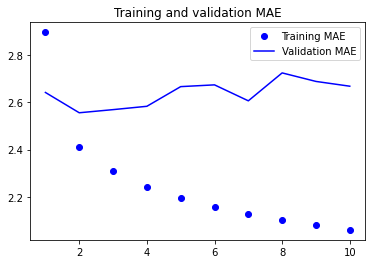

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 17ms/step - loss: 23.1412 - mae: 3.7646 - val_loss: 16.7161 - val_mae: 3.2417
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 15.8373 - mae: 3.1584 - val_loss: 20.0253 - val_mae: 3.5735
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 14.3867 - mae: 3.0096 - val_loss: 15.5272 - val_mae: 3.1268
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 13.4213 - mae: 2.9007 - val_loss: 18.4565 - val_mae: 3.4192
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 12.7452 - mae: 2.8240 - val_loss: 18.8360 - val_mae: 3.4270
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 12.2376 - mae: 2.7637 - val_loss: 14.1193 - val_mae: 2.9607
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 11.7072 - mae: 2.7048 - val_loss: 13.8402 - val_mae: 2.9335
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 25s 28ms/step - loss: 45.0976 - mae: 4.9105 - val_loss: 13.4066 - val_mae: 2.7662
Epoch 2/10
819/819 [==============================] - 24s 29ms/step - loss: 11.2296 - mae: 2.6018 - val_loss: 9.5987 - val_mae: 2.4060
Epoch 3/10
819/819 [==============================] - 24s 29ms/step - loss: 9.8095 - mae: 2.4400 - val_loss: 9.6775 - val_mae: 2.4065
Epoch 4/10
819/819 [==============================] - 24s 29ms/step - loss: 9.3071 - mae: 2.3744 - val_loss: 9.6153 - val_mae: 2.4028
Epoch 5/10
819/819 [==============================] - 24s 30ms/step - loss: 8.9528 - mae: 2.3307 - val_loss: 9.5712 - val_mae: 2.3995
Epoch 6/10
819/819 [==============================] - 24s 29ms/step - loss: 8.7250 - mae: 2.3008 - val_loss: 9.7753 - val_mae: 2.4208
Epoch 7/10
819/819 [==============================] - 24s 29ms/step - loss: 8.4618 - mae: 2.2644 - val_loss: 9.8133 - val_mae: 2.4302
Epoch 8/10
819/819 [==============================] - 25s 3

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [31]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [32]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [33]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [34]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [35]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [41]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    batch_size=20,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 80s 96ms/step - loss: 27.1277 - mae: 3.8640 - val_loss: 9.8648 - val_mae: 2.4381
Epoch 2/5
819/819 [==============================] - 78s 96ms/step - loss: 14.9340 - mae: 3.0031 - val_loss: 9.7566 - val_mae: 2.4247
Epoch 3/5
819/819 [==============================] - 76s 92ms/step - loss: 14.1258 - mae: 2.9199 - val_loss: 9.6738 - val_mae: 2.4194
Epoch 4/5
819/819 [==============================] - 75s 91ms/step - loss: 13.5730 - mae: 2.8582 - val_loss: 9.6907 - val_mae: 2.4178
Epoch 5/5
819/819 [==============================] - 75s 91ms/step - loss: 13.1094 - mae: 2.8099 - val_loss: 9.6697 - val_mae: 2.4074


In [42]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [43]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 183s 220ms/step - loss: 22.6270 - mae: 3.5451 - val_loss: 9.1671 - val_mae: 2.3421
Epoch 2/5
819/819 [==============================] - 154s 188ms/step - loss: 13.9726 - mae: 2.8965 - val_loss: 8.8499 - val_mae: 2.2990
Epoch 3/5
819/819 [==============================] - 151s 184ms/step - loss: 13.2246 - mae: 2.8173 - val_loss: 8.7388 - val_mae: 2.2824
Epoch 4/5
819/819 [==============================] - 150s 183ms/step - loss: 12.7060 - mae: 2.7643 - val_loss: 8.4861 - val_mae: 2.2440
Epoch 5/5
405/405 [==============================] - 13s 32ms/step - loss: 9.4866 - mae: 2.4026
Test MAE: 2.40


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [44]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
819/819 [==============================] - 43s 49ms/step - loss: 27.3567 - mae: 3.7598 - val_loss: 10.9045 - val_mae: 2.5628
Epoch 2/5
819/819 [==============================] - 41s 50ms/step - loss: 9.5038 - mae: 2.4057 - val_loss: 9.6775 - val_mae: 2.3983
Epoch 3/5
819/819 [==============================] - 41s 50ms/step - loss: 8.5129 - mae: 2.2717 - val_loss: 10.0033 - val_mae: 2.4344
Epoch 4/5
819/819 [==============================] - 40s 49ms/step - loss: 7.9315 - mae: 2.1947 - val_loss: 10.3493 - val_mae: 2.4728
Epoch 5/5
819/819 [==============================] - 41s 50ms/step - loss: 7.4446 - mae: 2.1316 - val_loss: 10.2516 - val_mae: 2.4578


### Going even further

## Summary